# Empherical Testing on PASCAL dataset

In [45]:
import mxnet as mx
import numpy as np
from mxnet import image
from mxnet.gluon.data.vision import transforms
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pandas as pd
import os
from os import path
import argparse
#import tensorflow as tf
import cv2
from skimage.measure import compare_ssim as ssim
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import scipy.io as sio
import matplotlib.image as image
import pandas as pd
import matplotlib.pyplot as plt
from mxnet import image
from mxnet.gluon.data.vision import transforms
import csv
# using cpu
ctx = mx.cpu(0)


In [46]:

class semantic_segmentation_pascal:
    def __init__(self):
        self.model=gluoncv.model_zoo.get_model('fcn_resnet101_voc', pretrained=True)

    def get_model(self):
        return self.model

In [47]:
code='pascal_segment_final'
model = semantic_segmentation_pascal().get_model()
pca = PCA(n_components=5) #2,5,7,10,13 

In [48]:
#pathe where masked images are stored before PCA
save_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\irtex-1.0\\segmentation\\Segmentation_CNN\\segmented_image_pascal_final\\'

def extract_features(img):
        img = test_transform(img, ctx)
        output = model.predict(img)
        predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
        mask = get_color_pallete(predict, 'pascal_voc')
        mask = mask.resize((128,128))
        mask_array=np.asarray(mask).flatten()

        return mask,mask_array


def segment_pascal_dataset(filename):
    feature_list = []
    # dataFile = os.getcwd()
    # print(dataFile)
    # save_path = os.path.join(dataFile, '/segmented_mask_pascal') #location to save segmented images 
    # print(save_path)

    for label in (os.listdir(filename)):
        for img_file in (os.listdir(os.path.join(filename, label))):
        
            img = image.imread(os.path.join(filename,label,img_file))   #<class 'mxnet.ndarray.ndarray.NDArray'>
            mask , mask_array = extract_features(img)
            name,extension=path.splitext(img_file)
            mask.save(save_path+name+'.png')

            ########## PCA ############
            mask = np.resize(mask,(128,128))
            mask = np.array(mask)
            mask_norm = normalize(mask)
            mask_pca = pca.fit_transform(mask_norm)
            
            segmented_img_pca=mask_pca.flatten() #1d array for the segmented image

            row = [img_file,segmented_img_pca,label]
            feature_list.append(row)
            # print(feature_list)
            # break
        
    df = pd.DataFrame(feature_list, columns=["file_name", code ,"label"])
    pd.to_pickle(df, code+'.pkl')



# Similarity Computation after Dimensionality Reduction with PCA

In [135]:

def similarity_images_pca(mask_query_img ):
    count=0
    n_components=13
    pca = PCA(n_components=n_components)   #2 5 7 10 13
    similarity=[]
    mask_query_img = np.array(mask_query_img)
    mask_query_img_norm = normalize(mask_query_img)
    mask_query_img = pca.fit_transform(mask_query_img_norm)
    mask_query_img  =mask_query_img.flatten()

    for img_file in tqdm(os.listdir(save_path)):
        img = image.imread(os.path.join(save_path,img_file))
        img = img.reshape((128,128))        
        img = img.asnumpy()
        
        img_norm = normalize(img)
        img = pca.fit_transform(img_norm)
        img=img.flatten()
        
        #print(mask_query_img.shape,type(mask_query_img),img.shape ,(type(img)))
        sim_ssim = ssim(mask_query_img.reshape(128,n_components), img.reshape(128,n_components),multichannel=True)
        sim_ari = adjusted_rand_score(mask_query_img.flatten(),img.flatten())
        
        #print (np.array(mask_query_img).shape, np.array(img).shape)
        
        #sim_jaccard = jaccard_similarity_score(np.array(mask_query_img).ravel(),np.array(img).ravel())
        row=[img_file,sim_ari,sim_ssim]
        similarity.append(row)
        
#         count=count+1
#         if(count==2000):
#             break
    
    return similarity

In [136]:
query_path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\VOCdevkit\\VOC2012\\JPEGImages\\2007_000027.jpg'
img = image.imread(query_path) 
print(type(img))
segmented_mask_query_img , predict_flat_query_img = extract_features(img) 

<class 'mxnet.ndarray.ndarray.NDArray'>


In [137]:
similarity_pca=similarity_images_pca(segmented_mask_query_img)



  0%|                                                 | 0/2229 [00:00<?, ?it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  0%|                                         | 1/2229 [00:01<39:56,  1.08s/it]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  0%|                                         | 2/2229 [00:01<29:14,  1.27it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\skl

  1%|▍                                       | 24/2229 [00:02<03:28, 10.58it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  1%|▍                                       | 26/2229 [00:02<04:02,  9.08it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has be

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  2%|▉                                       | 49/2229 [00:03<01:49, 19.89it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  3%|█▎                                      | 74/2229 [00:05<02:21, 15.19it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  3%|█▎                                      | 76/2229 [00:05<02:23, 15.05it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRE

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  4%|█▊                                      | 98/2229 [00:07<01:52, 18.88it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

  6%|██▏                                    | 124/2229 [00:08<01:30, 23.37it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurp

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  7%|██▋                                    | 151/2229 [00:09<01:14, 27.85it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


  8%|███  



  9%|███▌                                   | 203/2229 [00:11<01:12, 27.92it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 10%|████                                   | 231/2229 [00:12<01:19, 25.02it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 12%|████▌                                  | 258/2229 [00:13<01:09, 28.22it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 13%|█████                                  | 286/2229 [00:14<01:07, 28.74it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 14%|█████▍                                 | 310/2229 [00:14<01:12, 26.54it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 15%|█████▉                                 | 336/2229 [00:15<00:57, 32.94it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 16%|██████▎                                | 360/2229 [00:16<00:57, 32.32it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = expla

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 17%|██████▊                                | 387/2229 [00:18<02:52, 10.68it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 17%|██████▊                                | 389/2229 [00:18<03:34,  8.58it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRE

 18%|███████▏                               | 412/2229 [00:20<02:22, 12.76it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 19%|███████▏                               | 414/2229 [00:20<02:13, 13.62it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECA

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 20%|███████▋                               | 440/2229 [00:21<01:34, 19.00it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 21%|████████▏                              | 465/2229 [00:22<01:19, 22.06it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: Runt

 23%|████████▉                              | 513/2229 [00:25<01:21, 21.11it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = expla

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 24%|█████████▍                             | 542/2229 [00:25<00:53, 31.57it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 25%|█████████▉                             | 567/2229 [00:26<01:04, 25.89it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag



 27%|██████████▍                            | 594/2229 [00:27<00:55, 29.28it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gu

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 28%|██████████▊                            | 621/2229 [00:28<01:16, 21.10it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 29%|███████████▎                           | 648/2229 [00:30<01:03, 24.87it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 30%|███████████▊                           | 674/2229 [00:31<00:56, 27.32it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = exp

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages



 33%|████████████▋                          | 728/2229 [00:34<01:59, 12.53it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 33%|████████████▊                          | 731/2229 [00:35<01:53, 13.21it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWa



 34%|█████████████▏                         | 757/2229 [00:35<00:50, 29.35it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 35%|█████████████▊                         | 787/2229 [00:36<00:44, 32.71it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_



 36%|██████████████▏                        | 813/2229 [00:37<00:42, 33.11it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: 

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 39%|███████████████▏                       | 867/2229 [00:39<00:38, 35.23it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 40%|███████████████▋                       | 895/2229 [00:40<00:44, 29.67it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 41%|████████████████                       | 917/2229 [00:40<00:36, 35.55it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 42%|████████████████▍                      | 942/2229 [00:41<00:35, 36.15it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 43%|████████████████▉                      | 968/2229 [00:42<00:36, 34.58it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 45%|█████████████████▍                     | 998/2229 [00:43<00:33, 36.95it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 46%|█████████████████▍                    | 1025/2229 [00:43<00:32, 36.77it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 47%|█████████████████▉                    | 1049/2229 [00:44<00:45, 26.19it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 48%|██████████████████▎                   | 1075/2229 [00:46<01:37, 11.79it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 48%|██████████████████▎                   | 1077/2229 [00:47<02:17,  8.38it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_d

 49%|██████████████████▊                   | 1100/2229 [00:49<01:47, 10.49it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 49%|██████████████████▊                   | 1103/2229 [00:49<01:29, 12.54it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarn

 51%|███████████████████▏                  | 1126/2229 [00:50<00:45, 24.14it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 52%|███████████████████▋                  | 1154/2229 [00:51<00:41, 26.14it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = exp

 53%|████████████████████                  | 1179/2229 [00:51<00:32, 32.48it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 54%|████████████████████▌                 | 1209/2229 [00:52<00:28, 35.22it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

 56%|█████████████████████                 | 1239/2229 [00:53<00:34, 28.88it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 57%|█████████████████████▌                | 1266/2229 [00:54<00:29, 32.76it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurp

 58%|██████████████████████                | 1292/2229 [00:55<00:26, 35.16it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 60%|██████████████████████▉               | 1344/2229 [00:56<00:29, 30.49it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 61%|███████████████████████▎              | 1370/2229 [00:57<00:32, 26.65it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 62%|███████████████████████▍              | 1373/2229 [00:57<00:32, 26.63it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarn

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 63%|███████████████████████▊              | 1398/2229 [00:58<00:32, 25.96it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 64%|████████████████████████▎             | 1423/2229 [00:59<00:24, 33.54it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 65%|████████████████████████▋             | 1451/2229 [01:00<00:20, 37.72it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 66%|█████████████████████████▏            | 1478/2229 [01:01<00:21, 35.25it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 67%|█████████████████████████▌            | 1502/2229 [01:01<00:20, 35.34it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 69%|██████████████████████████            | 1530/2229 [01:02<00:24, 28.22it/s]C:\Users\Gu

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 70%|██████████████████████████▌           | 1555/2229 [01:03<00:26, 25.34it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 71%|██████████████████████████▉           | 1581/2229 [01:04<00:23, 27.01it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 72%|███████████████████████████▎          | 1605/2229 [01:05<00:19, 31.82it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurp

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 73%|███████████████████████████▊          | 1633/2229 [01:06<00:18, 31.54it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 74%|████████████████████████████▎         | 1660/2229 [01:07<00:17, 31.98it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

 76%|████████████████████████████▊         | 1689/2229 [01:08<00:21, 24.93it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurp

 77%|█████████████████████████████▏        | 1715/2229 [01:09<00:18, 28.23it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 78%|█████████████████████████████▋        | 1744/2229 [01:09<00:14, 34.18it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = expla

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 81%|██████████████████████████████▋       | 1798/

 82%|███████████████████████████████       | 1822/2229 [01:12<00:13, 30.72it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si



 83%|███████████████████████████████▌      | 1849/2229 [01:13<00:10, 37.10it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_



 84%|███████████████████████████████▉      | 1875/2229 [01:13<00:08, 40.88it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 86%|████████████████████████████████▌     | 1907/

 87%|████████████████████████████████▉     | 1930/2229 [01:15<00:09, 31.77it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimag

 88%|█████████████████████████████████▎    | 1957/2229 [01:16<00:13, 19.58it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

 89%|█████████████████████████████████▊    | 1984/2229 [01:18<00:14, 17.04it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_si

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 90%|██████████████████████████████████▎   | 2013/2229 [01:19<00:11, 18.36it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 92%|██████████████████████████████████▊   | 2040/2229 [01:20<00:06, 30.07it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 93%|███████████████████████████████████▏  | 2067/2229 [01:21<00:04, 35.78it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: 

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 95%|████████████████████████████████████  | 2119/2229 [01:23<00:03, 28.89it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skim

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 96%|████████████████████████████████████▌ | 2147/2229 [01:23<00:02, 38.01it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = exp



 97%|█████████████████████████████████████ | 2172/2229 [01:24<00:01, 30.45it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_

C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


 99%|█████████████████████████████████████▌| 2203/2229 [01:25<00:00, 31.57it/s]C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
C:\Users\Gurpreet\python\anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = exp



100%|██████████████████████████████████████| 2229/2229 [01:26<00:00, 25.85it/s]


In [138]:
import csv

path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\pascal_labels.csv'
ari_pca=[]
ssim_pca=[]
    
for i in range(len(similarity_pca)):
    filename,extension = similarity_pca[i][0].split('.')
    ari_val= similarity_pca[i][1]
    ssim_val = similarity_pca[i][2]
    count=0
    labels=[]
    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if(count==0):
                count=count+1
            else:
                name,ext = row[0].split('.')
                if(filename==name):
                    labels.append(row[1])
                    
        entry_ari=[filename+'.jpg',ari_val,labels]
        entry_ssim=[filename+'.jpg',ssim_val,labels]
    ari_pca.append(entry_ari)
    ssim_pca.append(entry_ssim)

In [139]:
ari_pca = sorted(ari_pca , key=lambda ari:ari[1] ,reverse=True)
ssim_pca = sorted(ssim_pca , key=lambda ssim:ssim[1] ,reverse=True)

In [140]:
#label_query
path='C:\\Users\\Gurpreet\\Desktop\\python\\IRTEX-Segmentation\\pascal_labels.csv'
query_file_name= '000999.jpg'
query_labels=[]
with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if(count==0):
                count=count+1
            else:
                if(query_file_name==row[0]):
                    query_labels.append(row[1])


In [141]:
top_k=[100,200,300,400,500]

precision_score_ari_pca=[]
precision_score_ssim_pca=[]

recall_score_ari_pca=[]
recall_score_ssim_pca=[]

f1_score_ari_pca=[]
f1_score_ssim_pca=[]


rel_ari_pca=0
rel_ssim_pca=0

for i in range(len(ari_pca)):
    query_labels=set(query_labels)
    labels_ari=set(ari_pca[i][2])
    labels_ssim=set(ssim_pca[i][2])
    if(len(query_labels.intersection(labels_ari))>0):
            rel_ari_pca=rel_ari_pca+1
    if(len(query_labels.intersection(labels_ssim))>0):
            rel_ssim_pca=rel_ssim_pca+1

print(rel_ari_pca, rel_ssim_pca)
            
for i in top_k:
    rel_ret_ari_pca=0
    rel_ret_ssim_pca=0
    for j in range(i):
        query_labels=set(query_labels)
        labels_ari=set(ari_pca[j][2])
        labels_ssim=set(ssim_pca[j][2])
        if(len(query_labels.intersection(labels_ari))>0):
            rel_ret_ari_pca = rel_ret_ari_pca + 1
        if(len(query_labels.intersection(labels_ssim))>0):
            rel_ret_ssim_pca = rel_ret_ssim_pca + 1
            
    print(rel_ret_ari_pca,rel_ret_ssim_pca)
    
    precision_ari_pca = rel_ret_ari_pca/i
    precision_ssim_pca = rel_ret_ssim_pca/i
    
    recall_ari_pca = rel_ret_ari_pca/rel_ari_pca
    recall_ssim_pca = rel_ret_ari_pca/rel_ssim_pca
    
    f1_ari_pca = ((2*precision_ari_pca * recall_ari_pca)/(precision_ari_pca + recall_ari_pca))
    f1_ssim_pca = ((2*precision_ssim_pca * recall_ssim_pca)/(precision_ssim_pca + recall_ssim_pca))
    
    precision_score_ari_pca.append(precision_ari_pca)
    precision_score_ssim_pca.append(precision_ssim_pca)
    
    recall_score_ari_pca.append(recall_ari_pca)
    recall_score_ssim_pca.append(recall_ssim_pca)
    
    f1_score_ari_pca.append(f1_ari_pca)
    f1_score_ssim_pca.append(f1_ssim_pca)
    
    
print("precision",precision_score_ari_pca,precision_score_ssim_pca)
print("recall",recall_score_ari_pca,recall_score_ssim_pca)
print("f1score",f1_score_ari_pca,f1_score_ssim_pca)

1221 1221
54 29
110 66
159 89
225 119
277 193
precision [0.54, 0.55, 0.53, 0.5625, 0.554] [0.29, 0.33, 0.2966666666666667, 0.2975, 0.386]
recall [0.044226044226044224, 0.09009009009009009, 0.13022113022113022, 0.18427518427518427, 0.22686322686322685] [0.044226044226044224, 0.09009009009009009, 0.13022113022113022, 0.18427518427518427, 0.22686322686322685]
f1score [0.0817562452687358, 0.15482054890921887, 0.20907297830374752, 0.2776064157927205, 0.3219058686809994] [0.07674777622583254, 0.1415397812567017, 0.18099495424284864, 0.2275827776573636, 0.28577079430072727]


### Precision / Recall / F1-score for PCA componenets 2/5/7/10/13

In [110]:
precision_score_ari_pca_2 , precision_score_ssim_pca_2 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_2 , recall_score_ssim_pca_2 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_2 , f1_score_ssim_pca_2 = f1_score_ari_pca , f1_score_ssim_pca

In [118]:
precision_score_ari_pca_5 , precision_score_ssim_pca_5 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_5 , recall_score_ssim_pca_5 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_5 , f1_score_ssim_pca_5 = f1_score_ari_pca , f1_score_ssim_pca

In [126]:
precision_score_ari_pca_7 , precision_score_ssim_pca_7 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_7 , recall_score_ssim_pca_7 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_7 , f1_score_ssim_pca_7 = f1_score_ari_pca , f1_score_ssim_pca

In [134]:
precision_score_ari_pca_10 , precision_score_ssim_pca_10 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_10 , recall_score_ssim_pca_10 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_10 , f1_score_ssim_pca_10 = f1_score_ari_pca , f1_score_ssim_pca

In [142]:
precision_score_ari_pca_13 , precision_score_ssim_pca_13 = precision_score_ari_pca , precision_score_ssim_pca
recall_score_ari_pca_13 , recall_score_ssim_pca_13 = recall_score_ari_pca , recall_score_ssim_pca
f1_score_ari_pca_13 , f1_score_ssim_pca_13 = f1_score_ari_pca , f1_score_ssim_pca

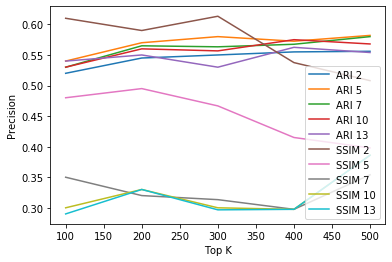

In [143]:
plt.figure("Precision_PCA")
plt.xlabel('Top K')
plt.ylabel('Precision')
plt.plot(top_k, precision_score_ari_pca_2)
plt.plot(top_k, precision_score_ari_pca_5)
plt.plot(top_k, precision_score_ari_pca_7)
plt.plot(top_k, precision_score_ari_pca_10)
plt.plot(top_k, precision_score_ari_pca_13)

plt.plot(top_k, precision_score_ssim_pca_2)
plt.plot(top_k, precision_score_ssim_pca_5)
plt.plot(top_k, precision_score_ssim_pca_7)
plt.plot(top_k, precision_score_ssim_pca_10)
plt.plot(top_k, precision_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()




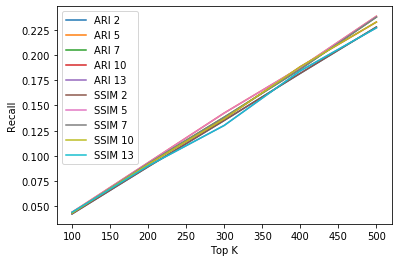

In [144]:


plt.figure("Recall_PCA")
plt.xlabel('Top K')
plt.ylabel('Recall')
plt.plot(top_k, recall_score_ari_pca_2)
plt.plot(top_k, recall_score_ari_pca_5)
plt.plot(top_k, recall_score_ari_pca_7)
plt.plot(top_k, recall_score_ari_pca_10)
plt.plot(top_k, recall_score_ari_pca_13)

plt.plot(top_k, recall_score_ssim_pca_2)
plt.plot(top_k, recall_score_ssim_pca_5)
plt.plot(top_k, recall_score_ssim_pca_7)
plt.plot(top_k, recall_score_ssim_pca_10)
plt.plot(top_k, recall_score_ssim_pca_13)

plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()



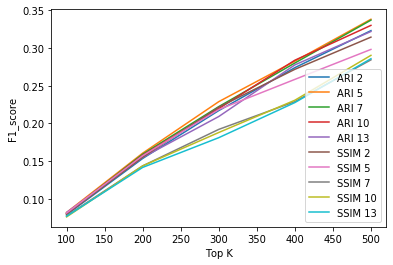

In [145]:
plt.figure("F1 Score PCA")
plt.xlabel('Top K')
plt.ylabel('F1_score')
plt.plot(top_k, f1_score_ari_pca_2)
plt.plot(top_k, f1_score_ari_pca_5)
plt.plot(top_k, f1_score_ari_pca_7)
plt.plot(top_k, f1_score_ari_pca_10)
plt.plot(top_k, f1_score_ari_pca_13)

plt.plot(top_k, f1_score_ssim_pca_2)
plt.plot(top_k, f1_score_ssim_pca_5)
plt.plot(top_k, f1_score_ssim_pca_7)
plt.plot(top_k, f1_score_ssim_pca_10)
plt.plot(top_k, f1_score_ssim_pca_13)


plt.legend(["ARI 2", "ARI 5","ARI 7","ARI 10" , "ARI 13" , "SSIM 2" , "SSIM 5" ,"SSIM 7","SSIM 10" , "SSIM 13"])

plt.show()